# Intro to Random Forests

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [5]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import PIL, os, numpy as np, math, collections, threading, json, bcolz, random, scipy, cv2

from sklearn import metrics

In [6]:
PATH = "data/bulldozers/"

In [7]:
!ls {PATH}

Data Dictionary.xlsx Train.csv            _DS_Store
Test.csv             Valid.csv


# Introduction to *Blue Book for Bulldozers*

### ...this dataset

We will be looking at the Blue Book for Bulldozers Kaggle Competition: "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

This is a very common type of dataset and prediciton problem, and similar to what you may see in your project or workplace.

### ...Kaggle Competitions

Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills.  There is nothing like being able to get hands-on practice and receiving real-time feedback to help you improve your skills.

Kaggle provides:

1. Interesting data sets
2. Feedback on how you're doing
3. A leader board to see what's good, what's possible, and what's state-of-art.
4. Blog posts by winning contestants share useful tips and techniques.

## The data

### Look at the data

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012. You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

In [8]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [9]:
print('{}Train.csv'.format(PATH))

data/bulldozers/Train.csv


In [10]:
df_raw.shape

(401125, 53)

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [11]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [12]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
display_all(df_raw.head().transpose())

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [14]:
display_all(df_raw.describe(include='all').transpose())

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [15]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### Initial processing

In [16]:
m = RandomForestRegressor(n_jobs=-1)
# The following code is supposed to fail due to string values in the input data
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

/Users/jaimesolis/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: 'Low'

This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

## Feature engineering

In [18]:
## Feature engineering functions

## conda install python-graphviz

import pandas as pd, pickle, sys, itertools, string, sys, re, datetime, time, shutil, copy
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
import IPython, graphviz, sklearn, warnings, pdb
# sklearn_pandas

def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)          # controls default text sizes
    plt.rc('axes', titlesize=sml)     # fontsize of the axes title
    plt.rc('axes', labelsize=med)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sml)    # legend fontsizeç
    plt.rc('figure', titlesize=big)  # fontsize of the figure title

def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

def combine_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def add_datepart(df, fldname, drop=True, time=False, errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

def is_date(x): return np.issubdtype(x.dtype, np.datetime64)

def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

def get_nn_mappers(df, cat_vars, contin_vars):
    # Replace nulls with 0 for continuous, "" for categorical.
    for v in contin_vars: df[v] = df[v].fillna(df[v].max()+100,)
    for v in cat_vars: df[v].fillna('#NA#', inplace=True)

    # list of tuples, containing variable and instance of a transformer for that variable
    # for categoricals, use LabelEncoder to map to integers. For continuous, standardize
    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]


In [19]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()
add_datepart()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [21]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [22]:
train_cats(df_raw)

We can specify the order to use for categorical variables if we wish:

In [23]:
df_raw.UsageBand

0            Low
1            Low
2           High
3           High
4         Medium
5            Low
6           High
7           High
8            Low
9         Medium
10        Medium
11           Low
12           NaN
13        Medium
14           Low
15        Medium
16           Low
17           NaN
18           Low
19        Medium
20        Medium
21        Medium
22           Low
23          High
24        Medium
25        Medium
26           Low
27           NaN
28           Low
29        Medium
           ...  
401095       NaN
401096       NaN
401097       NaN
401098       NaN
401099       NaN
401100       NaN
401101       NaN
401102       NaN
401103       NaN
401104       NaN
401105       NaN
401106       NaN
401107       NaN
401108       NaN
401109       NaN
401110       NaN
401111       NaN
401112       NaN
401113       NaN
401114       NaN
401115       NaN
401116       NaN
401117       NaN
401118       NaN
401119       NaN
401120       NaN
401121       NaN
401122       N

In [24]:
df_raw.UsageBand.cat.categobries

AttributeError: 'CategoricalAccessor' object has no attribute 'categobries'

In [25]:
df_raw.UsageBand.cat.codes

0         1
1         1
2         0
3         0
4         2
5         1
6         0
7         0
8         1
9         2
10        2
11        1
12       -1
13        2
14        1
15        2
16        1
17       -1
18        1
19        2
20        2
21        2
22        1
23        0
24        2
25        2
26        1
27       -1
28        1
29        2
         ..
401095   -1
401096   -1
401097   -1
401098   -1
401099   -1
401100   -1
401101   -1
401102   -1
401103   -1
401104   -1
401105   -1
401106   -1
401107   -1
401108   -1
401109   -1
401110   -1
401111   -1
401112   -1
401113   -1
401114   -1
401115   -1
401116   -1
401117   -1
401118   -1
401119   -1
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Length: 401125, dtype: int8

In [26]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [27]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

In [28]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [29]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [30]:
display_all(df.isnull().sum().sort_index()/len(df))

Backhoe_Mounting               0.0
Blade_Extension                0.0
Blade_Type                     0.0
Blade_Width                    0.0
Coupler                        0.0
Coupler_System                 0.0
Differential_Type              0.0
Drive_System                   0.0
Enclosure                      0.0
Enclosure_Type                 0.0
Engine_Horsepower              0.0
Forks                          0.0
Grouser_Tracks                 0.0
Grouser_Type                   0.0
Hydraulics                     0.0
Hydraulics_Flow                0.0
MachineHoursCurrentMeter       0.0
MachineHoursCurrentMeter_na    0.0
MachineID                      0.0
ModelID                        0.0
Pad_Type                       0.0
Pattern_Changer                0.0
ProductGroup                   0.0
ProductGroupDesc               0.0
ProductSize                    0.0
Pushblock                      0.0
Ride_Control                   0.0
Ripper                         0.0
SalesID             

We now have something we can pass to a random forest!

In [31]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

/Users/jaimesolis/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9830309826274444

In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [32]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [33]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [34]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/Users/jaimesolis/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 5s, sys: 575 ms, total: 1min 6s
Wall time: 21.8 s
[0.09062266271006122, 0.2492389433760931, 0.9828363968906049, 0.88906214183554]


An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

## Speeding things up

In [35]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [42]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/Users/jaimesolis/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 2.71 s, sys: 36.7 ms, total: 2.74 s
Wall time: 985 ms
[0.11214994118554227, 0.3983500131780098, 0.972841321882262, 0.7166144864196418]


## Single tree

In [60]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5213736376648395, 0.5839647094366263, 0.4130397869742193, 0.3909945507514966]


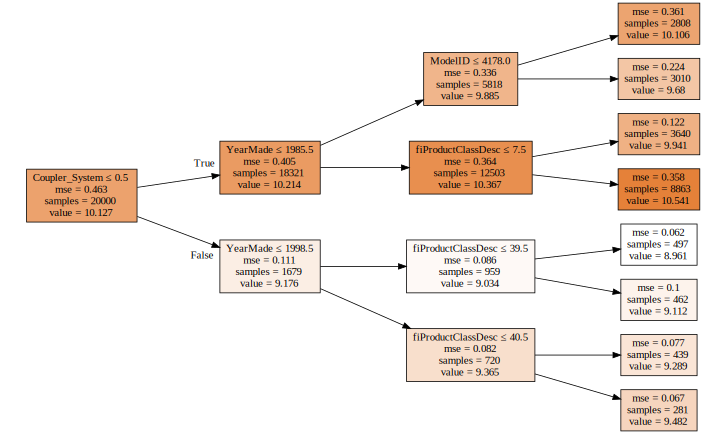

In [61]:
draw_tree(m.estimators_[0], df_trn, precision=3)

Let's see what happens if we create a bigger tree.

In [64]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[5.756054031998178e-17, 0.5670622323981335, 1.0, 0.42573887087303963]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [65]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/Users/jaimesolis/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11106631956182428, 0.3848036754945203, 0.9733636146583377, 0.7355604574675209]


We'll grab the predictions for each individual tree, and look at one example.

In [66]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([8.9226583 , 9.04782144, 9.21034037, 9.87816974, 8.98719682,
        9.30565055, 9.04782144, 8.98719682, 8.9226583 , 9.32812341]),
 9.163763720127065,
 9.104979856318357)

In [67]:
preds.shape

(10, 12000)

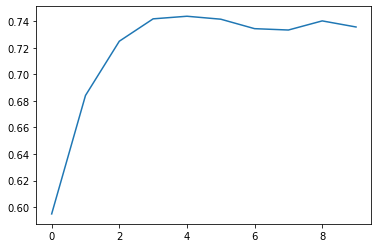

In [68]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [69]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.1019406940411286, 0.3779568232791865, 0.9775608862722147, 0.7448871384503959]


In [70]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09632172044213486, 0.37530045464794126, 0.979966400389119, 0.7484605221627711]


In [71]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09387871060334127, 0.36752006206170573, 0.9809697383419503, 0.7587817977864895]


### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [72]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09690312757508206, 0.38046088532950684, 0.9797238210226364, 0.7414955626690085, 0.8552476829030933]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [73]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [74]:
set_rf_samples(20000)

In [75]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

/Users/jaimesolis/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 7.22 s, sys: 534 ms, total: 7.75 s
Wall time: 4.6 s
[0.2395970581970145, 0.2767175815242956, 0.8800230578347976, 0.8632518433893523, 0.8674894391928307]


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [76]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.22750393645933997, 0.2642110333552825, 0.8918285485228186, 0.8753334694620296, 0.8802794534015661]


### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [77]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [78]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [79]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0781933886171304, 0.23546378278656369, 0.9872216466065702, 0.900986090754278, 0.9085314343090639]


In [80]:
t=m.estimators_[0].tree_

In [81]:
dectree_max_depth(t)

44

In [82]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14080918493812905, 0.2338082609131194, 0.9585621899455177, 0.9023735095689037, 0.9070504670867088]


In [86]:
t=m.estimators_[0].tree_

In [87]:
dectree_max_depth(t)

42

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [88]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11498660199326845, 0.2333966341179113, 0.9723669192291565, 0.9027169559907767, 0.9087136256014244]


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

- None
- 0.5
- 'sqrt'

- 1, 3, 5, 10, 25, 100

In [89]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11899152528562695, 0.2282586856867359, 0.970408506203464, 0.9069529521672812, 0.9118930389272333]


We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)